# TSB Method for Intermittent Time Series Forecasting in NumPyro

## Prepare Notebook

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import pandas as pd
import preliz as pz
import xarray as xr
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field
from statsforecast import StatsForecast
from statsforecast.models import TSB
from statsforecast.utils import ConformalIntervals
from tqdm.notebook import tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

We start by generating synthetic time series with many zeros. We use a Poisson distribution to generate the samples:

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

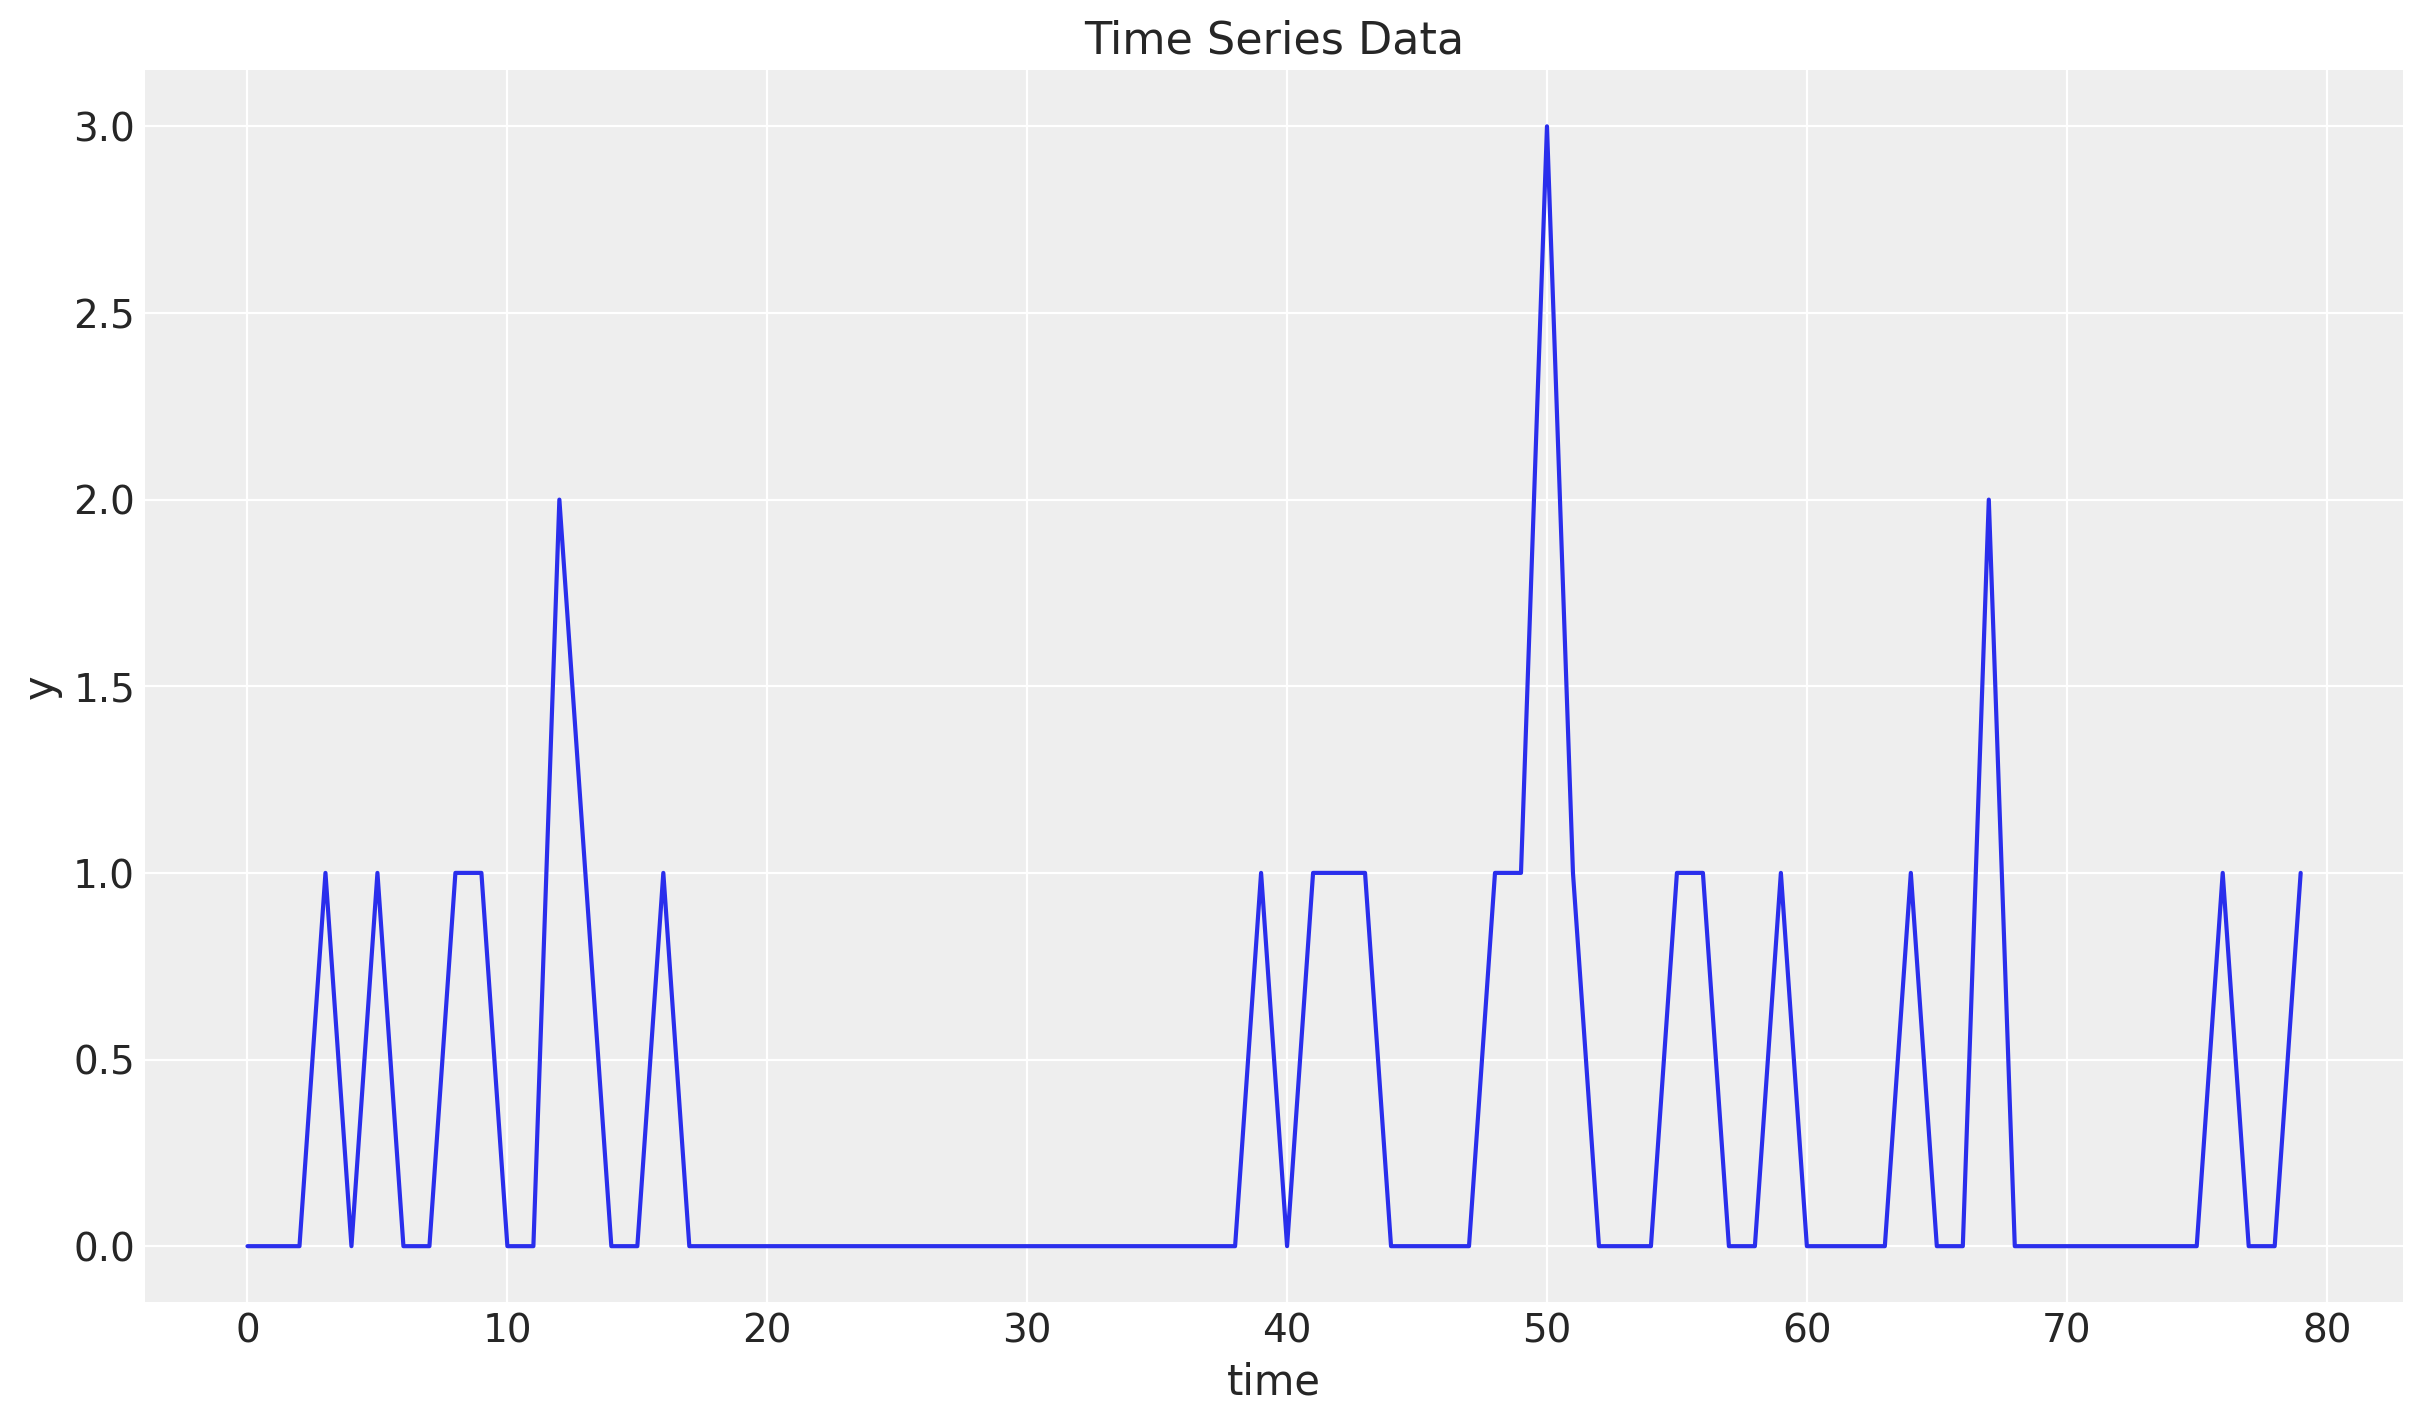

In [2]:
n = 80
lam = 0.3

y = random.poisson(key=rng_key, lam=lam, shape=(n,)).astype(jnp.float32)
t = jnp.arange(y.size)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

## Train-Test Split

Next, we split the data into a training and a test set. We will use the training set to fit the model and the test set to evaluate the model's performance.

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

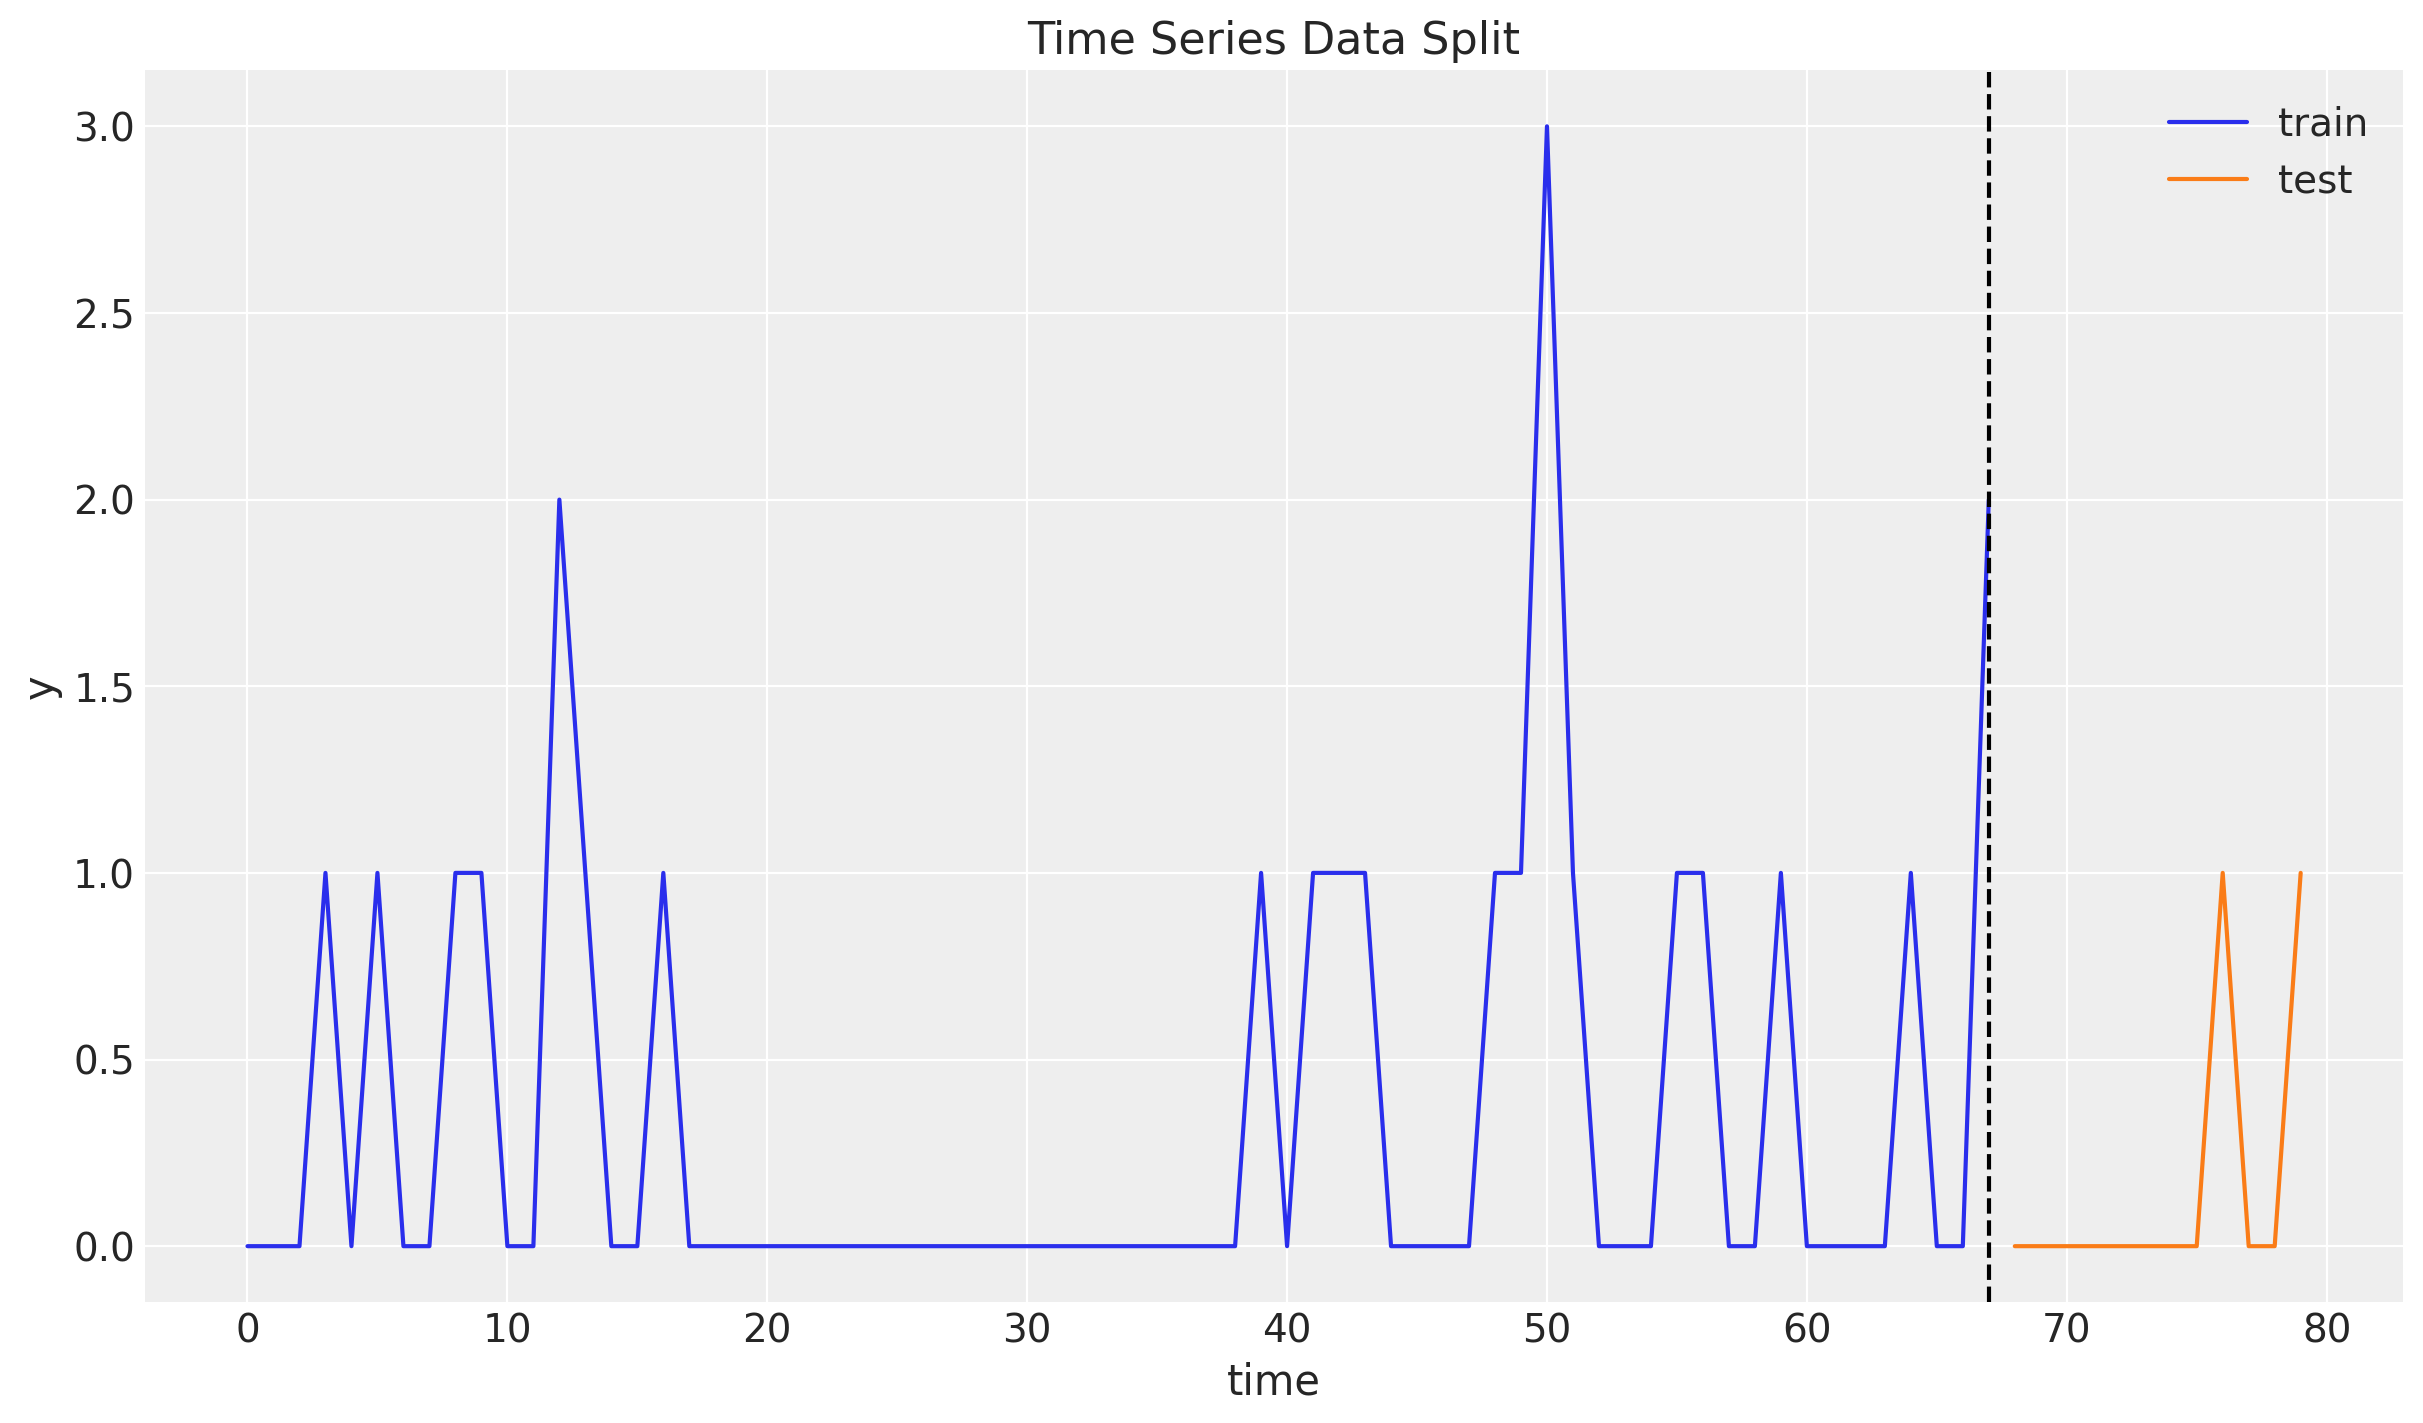

In [3]:
n = y.size

prop_train = 0.85
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

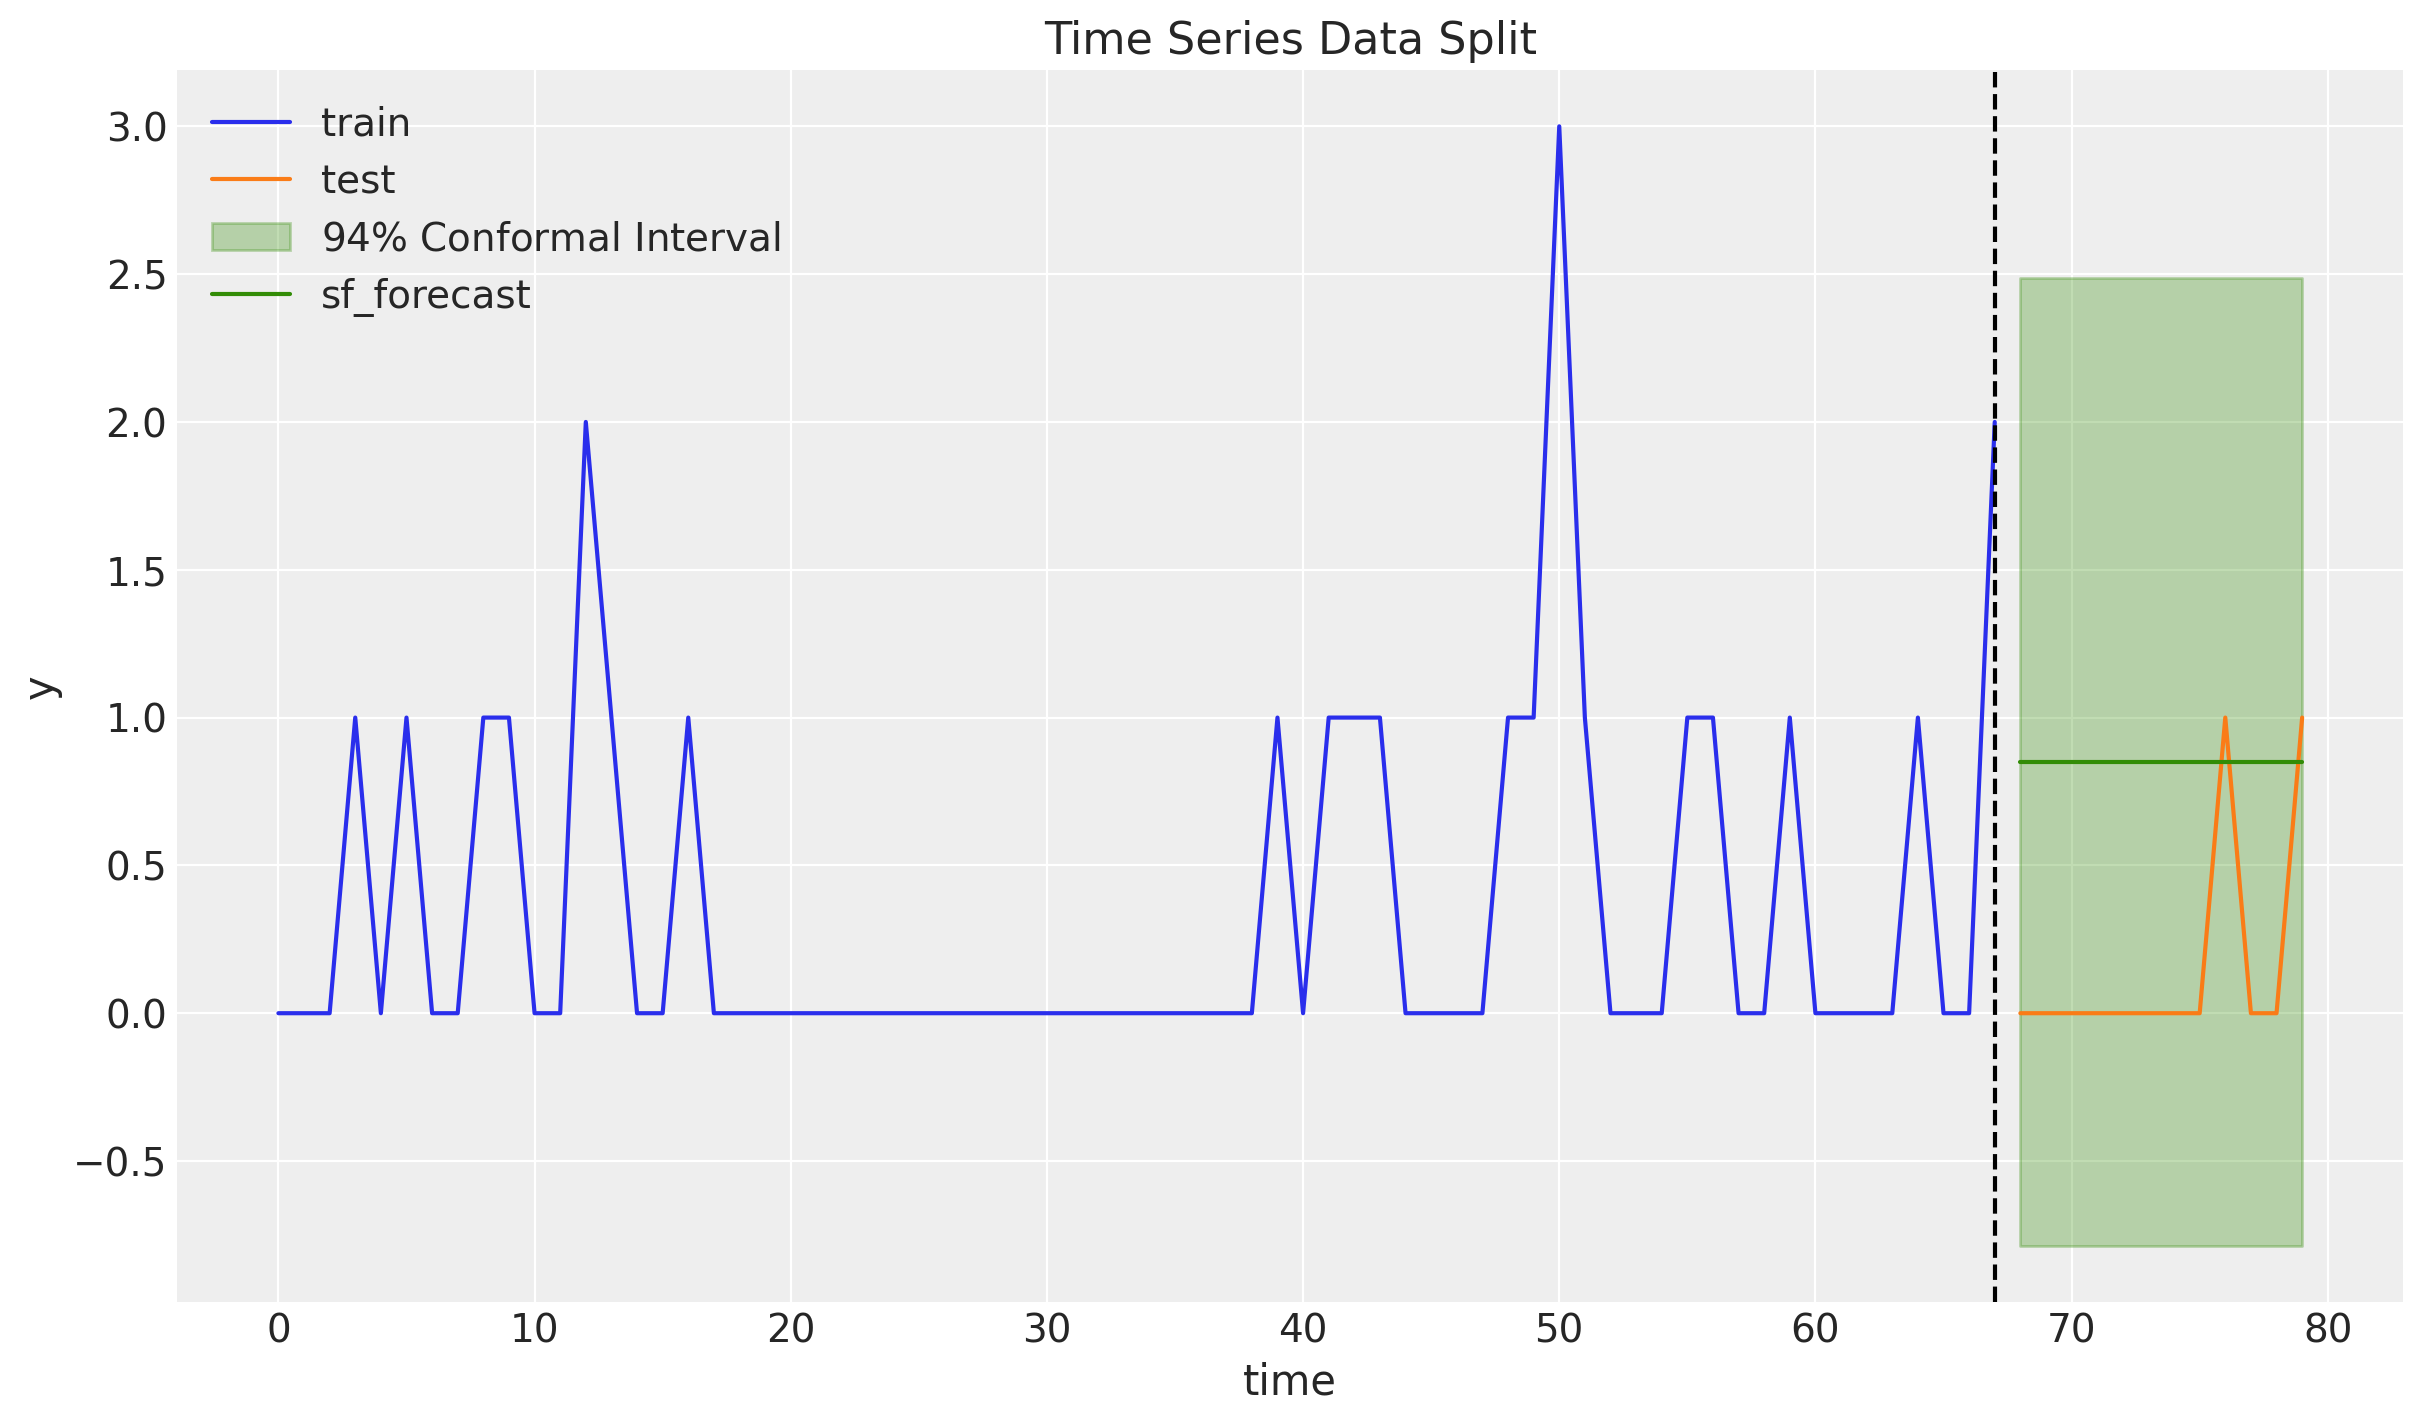

In [4]:
sf = StatsForecast(
    models=[TSB(alpha_d=0.311, alpha_p=0.57)],
    freq=1,
    n_jobs=-1,
)

train_df = pd.DataFrame({"unique_id": "a", "ds": t_train, "y": y_train})

sf_forecast = sf.forecast(
    h=y_test.size,
    df=train_df,
    level=[94],
    prediction_intervals=ConformalIntervals(n_windows=5),
)


fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.fill_between(
    t_test,
    sf_forecast["TSB-lo-94"],
    sf_forecast["TSB-hi-94"],
    color="C2",
    alpha=0.3,
    label="$94\\%$ Conformal Interval",
)
ax.plot(t_test, sf_forecast["TSB"], color="C2", label="sf_forecast")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

Recall the model structure for the simple exponential smoothing (level) model:

[Text(0.5, 1.0, 'Beta(10, 40) PDF'), Text(0.5, 0, '$\\alpha$')]

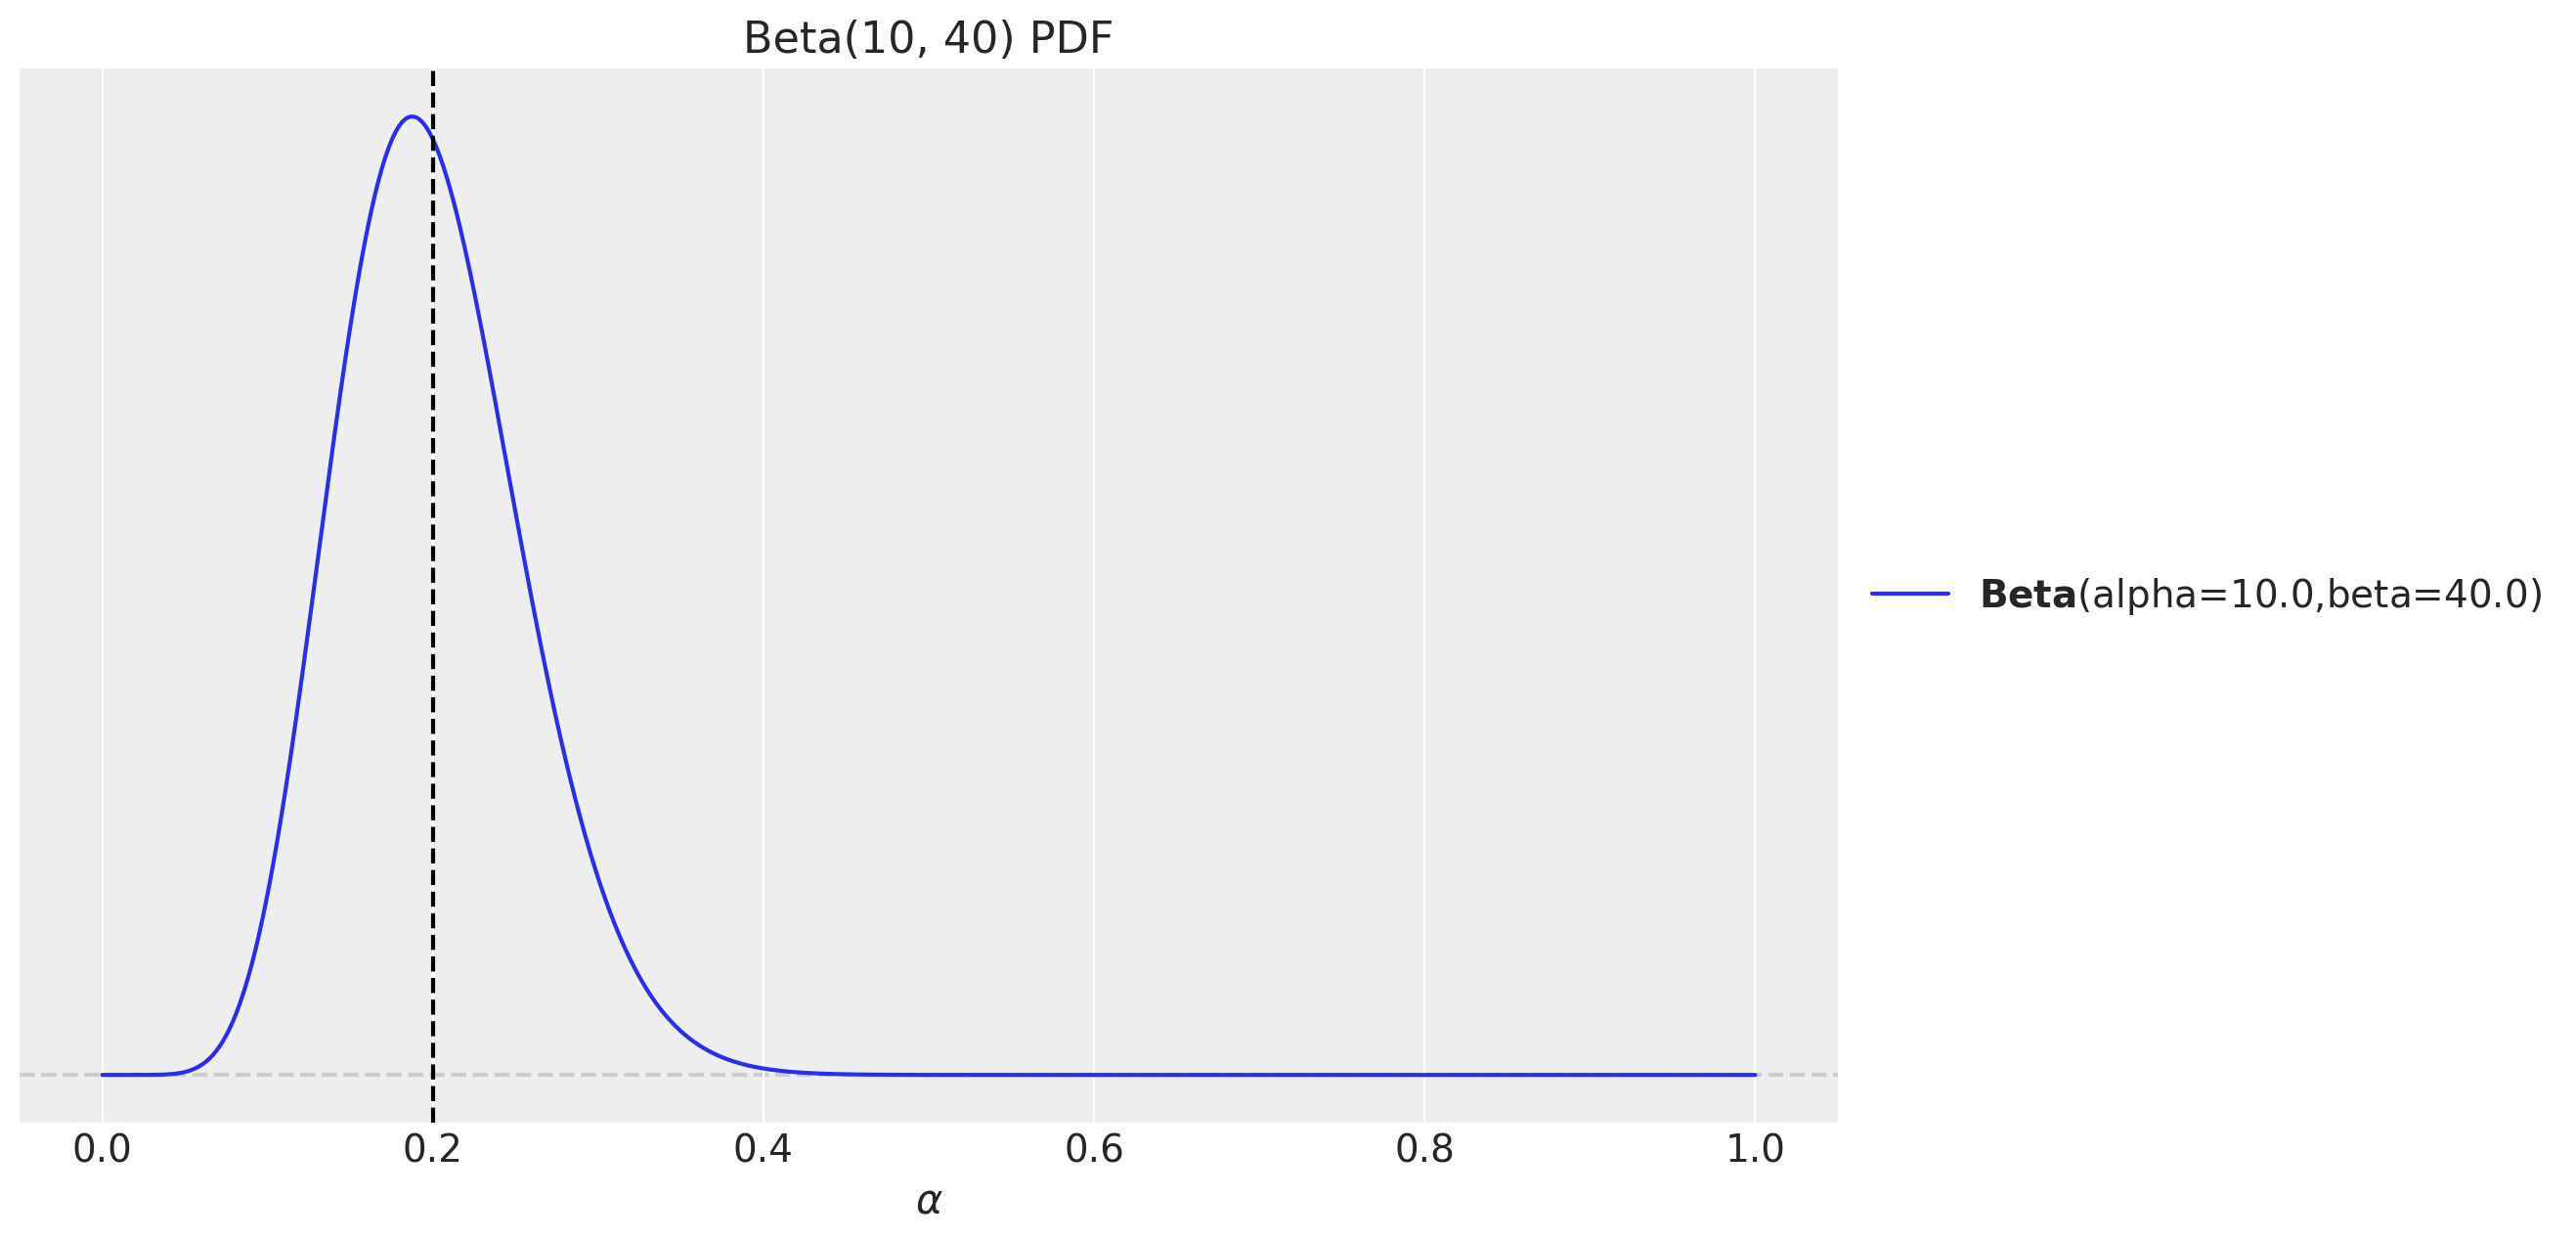

In [5]:
fig, ax = plt.subplots()
pz.Beta(10, 40).plot_pdf(ax=ax)
ax.axvline(x=(10 / (40 + 10)), c="black", linestyle="--")  # mean
ax.set(title="Beta(10, 40) PDF", xlabel="$\\alpha$")

In [6]:
def tsb_model(ts_trim: ArrayImpl, z0: float, p0: float, future: int = 0) -> None:
    t_max_trim = ts_trim.size

    # --- Priors ---

    z_smoothing = numpyro.sample(
        "z_smoothing", dist.Beta(concentration1=10, concentration0=40)
    )
    p_smoothing = numpyro.sample(
        "p_smoothing", dist.Beta(concentration1=10, concentration0=40)
    )
    noise = numpyro.sample("noise", dist.HalfNormal(scale=1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        z_prev, p_prev = carry

        z_next = jnp.where(
            t < t_max_trim,
            jnp.where(
                ts_trim[t] > 0,
                z_smoothing * ts_trim[t] + (1 - z_smoothing) * z_prev,
                z_prev,
            ),
            z_prev,
        )

        p_next = jnp.where(
            t < t_max_trim,
            jnp.where(
                ts_trim[t] > 0,
                p_smoothing + (1 - p_smoothing) * p_prev,
                (1 - p_smoothing) * p_prev,
            ),
            p_prev,
        )

        mu = z_next * p_next
        pred = numpyro.sample("pred", dist.Normal(loc=mu, scale=noise))

        return (z_next, p_next), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": ts_trim}):
        _, preds = scan(
            transition_fn,
            (z0, p0),
            jnp.arange(t_max_trim + future),
        )

    # --- Forecast ---

    if future > 0:
        return numpyro.deterministic("ts_forecast", preds[-future:])
    return None

### Inference

We now fit the model:

In [7]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [8]:
def get_model_args(y_train: ArrayImpl) -> tuple[ArrayImpl, float, float]:
    y_train_trim = jnp.trim_zeros(y_train, trim="f")
    p_idx = jnp.flatnonzero(y_train)
    p_diff = jnp.diff(p_idx, prepend=-1)
    z0 = y_train[p_idx[0]]
    p0 = 1 / p_diff.mean()
    return y_train_trim, z0, p0


y_train_trim, z0, p0 = get_model_args(y_train)

In [9]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
mcmc = run_inference(rng_subkey, tsb_model, inference_params, y_train_trim, z0, p0)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [10]:
idata = az.from_numpyro(posterior=mcmc)

az.summary(data=idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
noise,0.357,0.051,0.261,0.451,0.001,0.001,3162.0,3374.0,1.0
p_smoothing,0.570,0.079,0.416,0.710,0.001,0.001,3302.0,3883.0,1.0
z_smoothing,0.311,0.080,0.165,0.462,0.001,0.001,3483.0,4086.0,1.0


In [11]:
print(f"""Divergences: {idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


The model seems to be fitting well. Let's look into the trace:

Text(0.5, 0.98, 'Croston Model Trace')

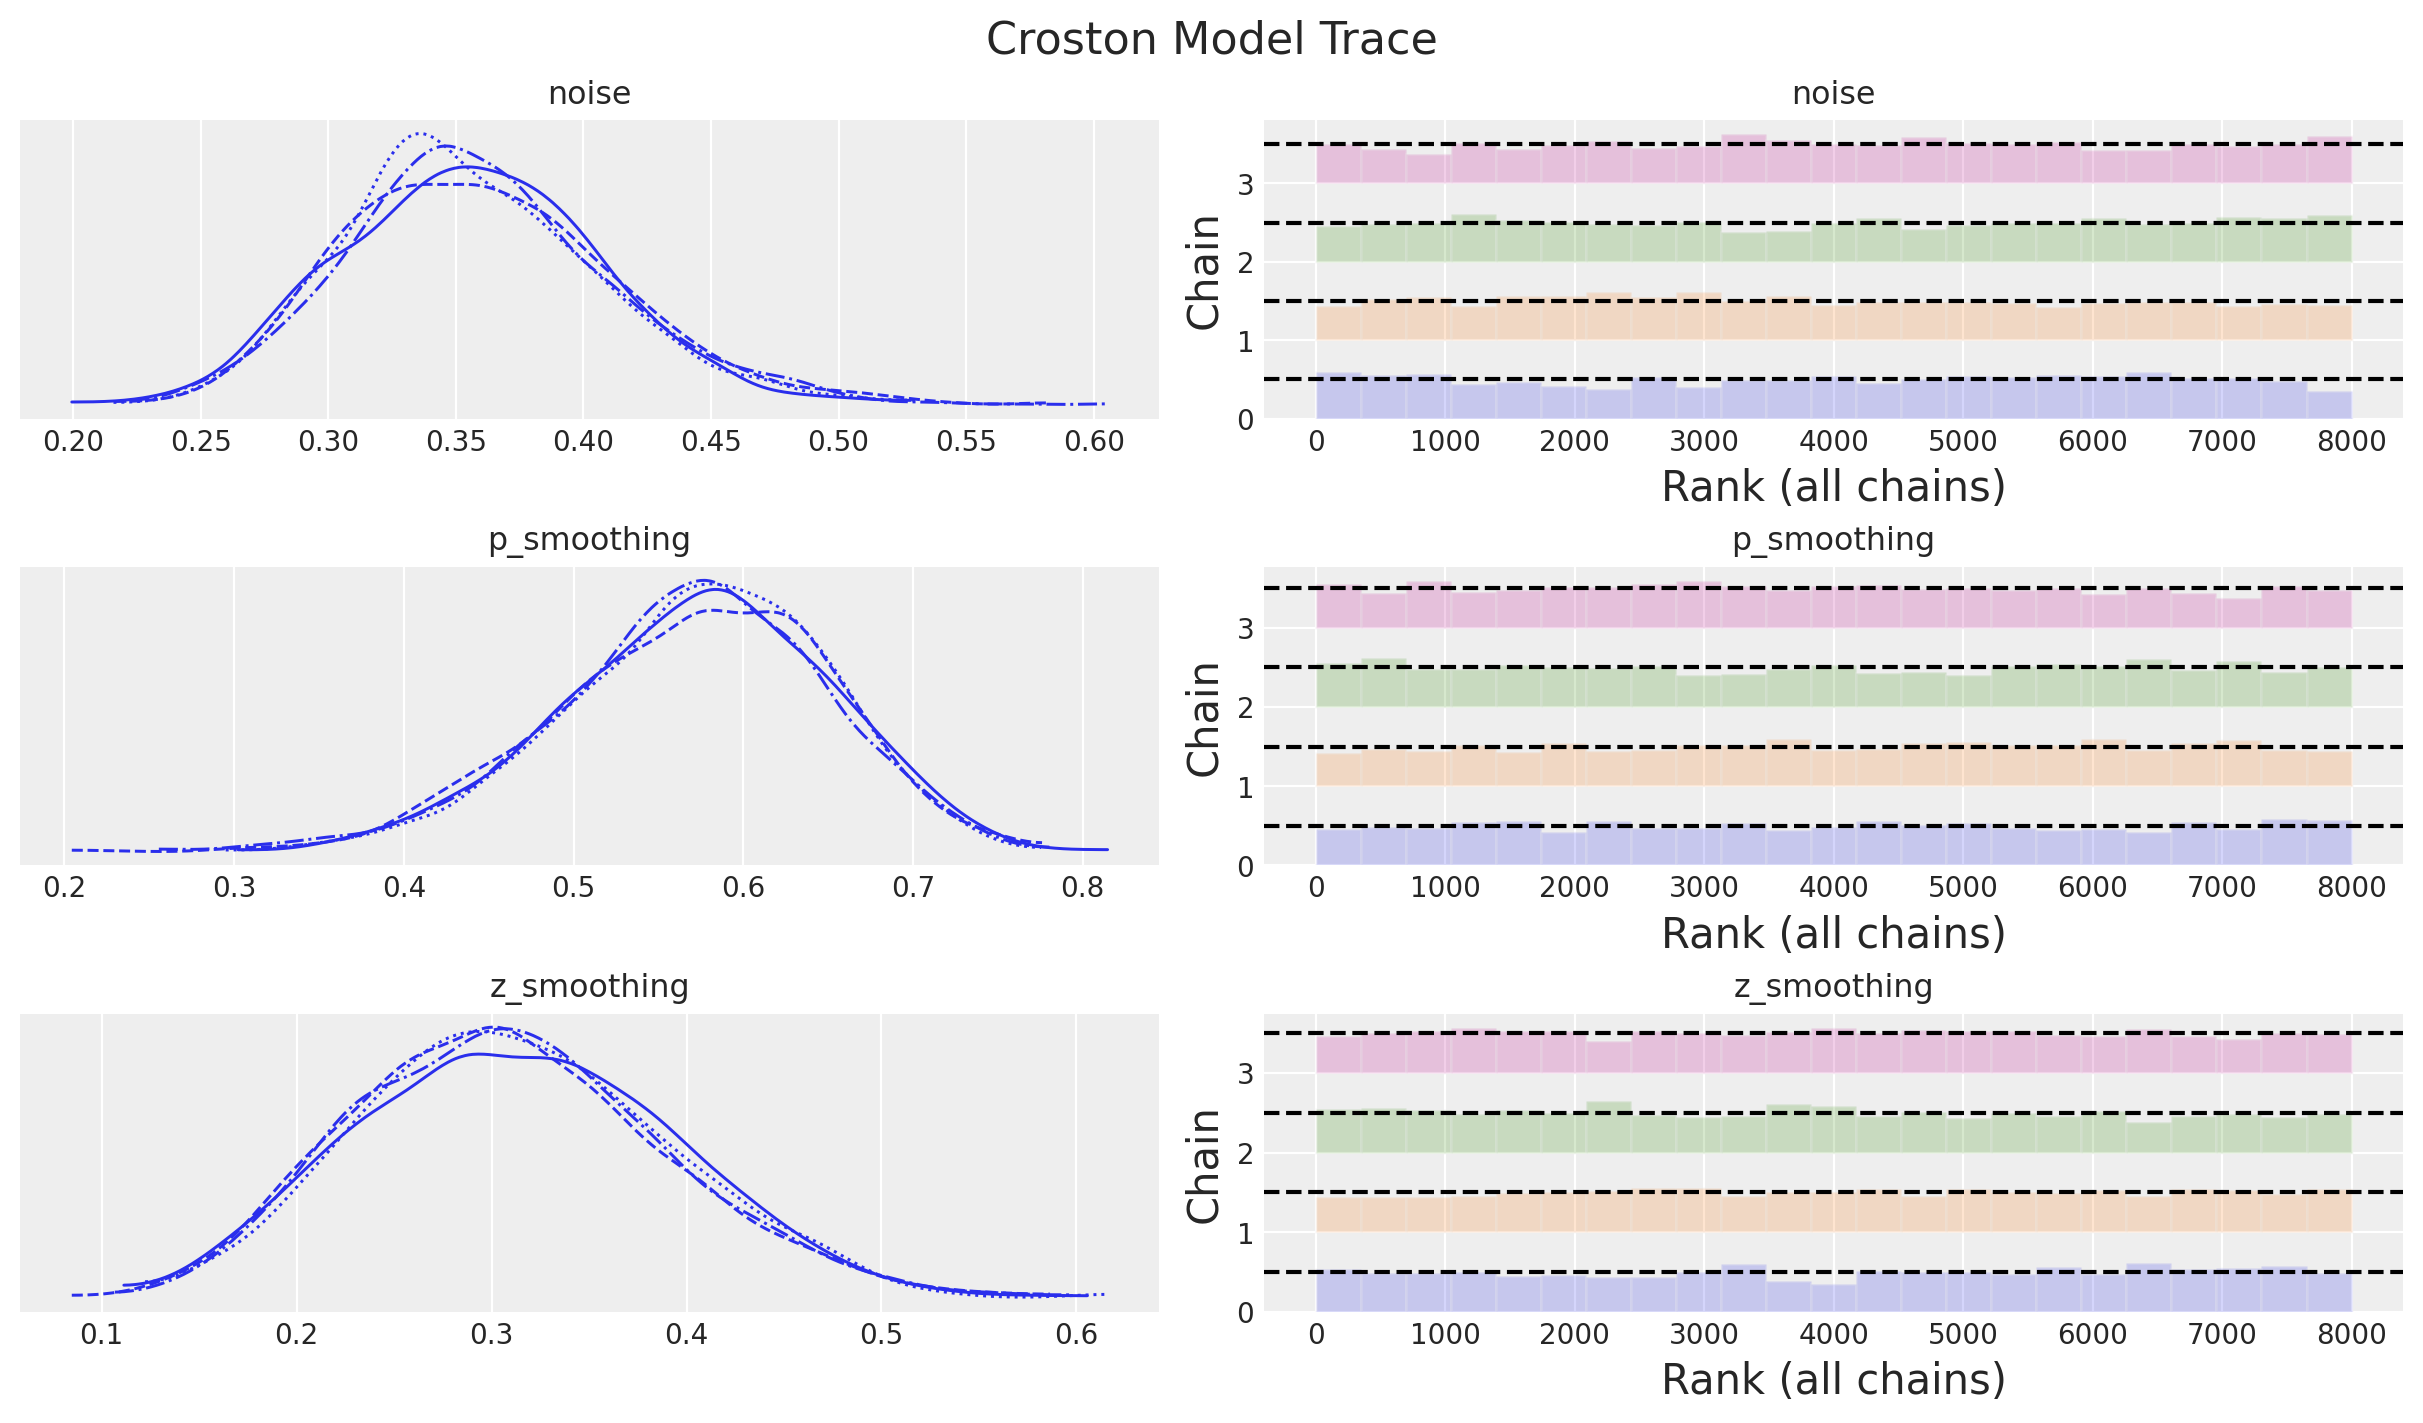

In [12]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Croston Model Trace", fontsize=16)

It is worth noting that the posterior distribution of the smoothing parameters between the demand size and the demand interval are different.

### Forecast

We now generate the forecast:

In [13]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["ts_forecast"],
    )
    return predictive(rng_key, *model_args)

In [14]:
rng_key, rng_subkey = random.split(key=rng_key)
tsb_forecast = forecast(
    rng_subkey, tsb_model, mcmc.get_samples(), y_train_trim, z0, p0, y_test.size
)

In [15]:
posterior_predictive = az.from_numpyro(
    posterior_predictive=tsb_forecast,
    coords={"t": t_test},
    dims={"ts_forecast": ["t"]},
)

We can combine the forecasts to get the final result:

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Croston Model Forecast')]

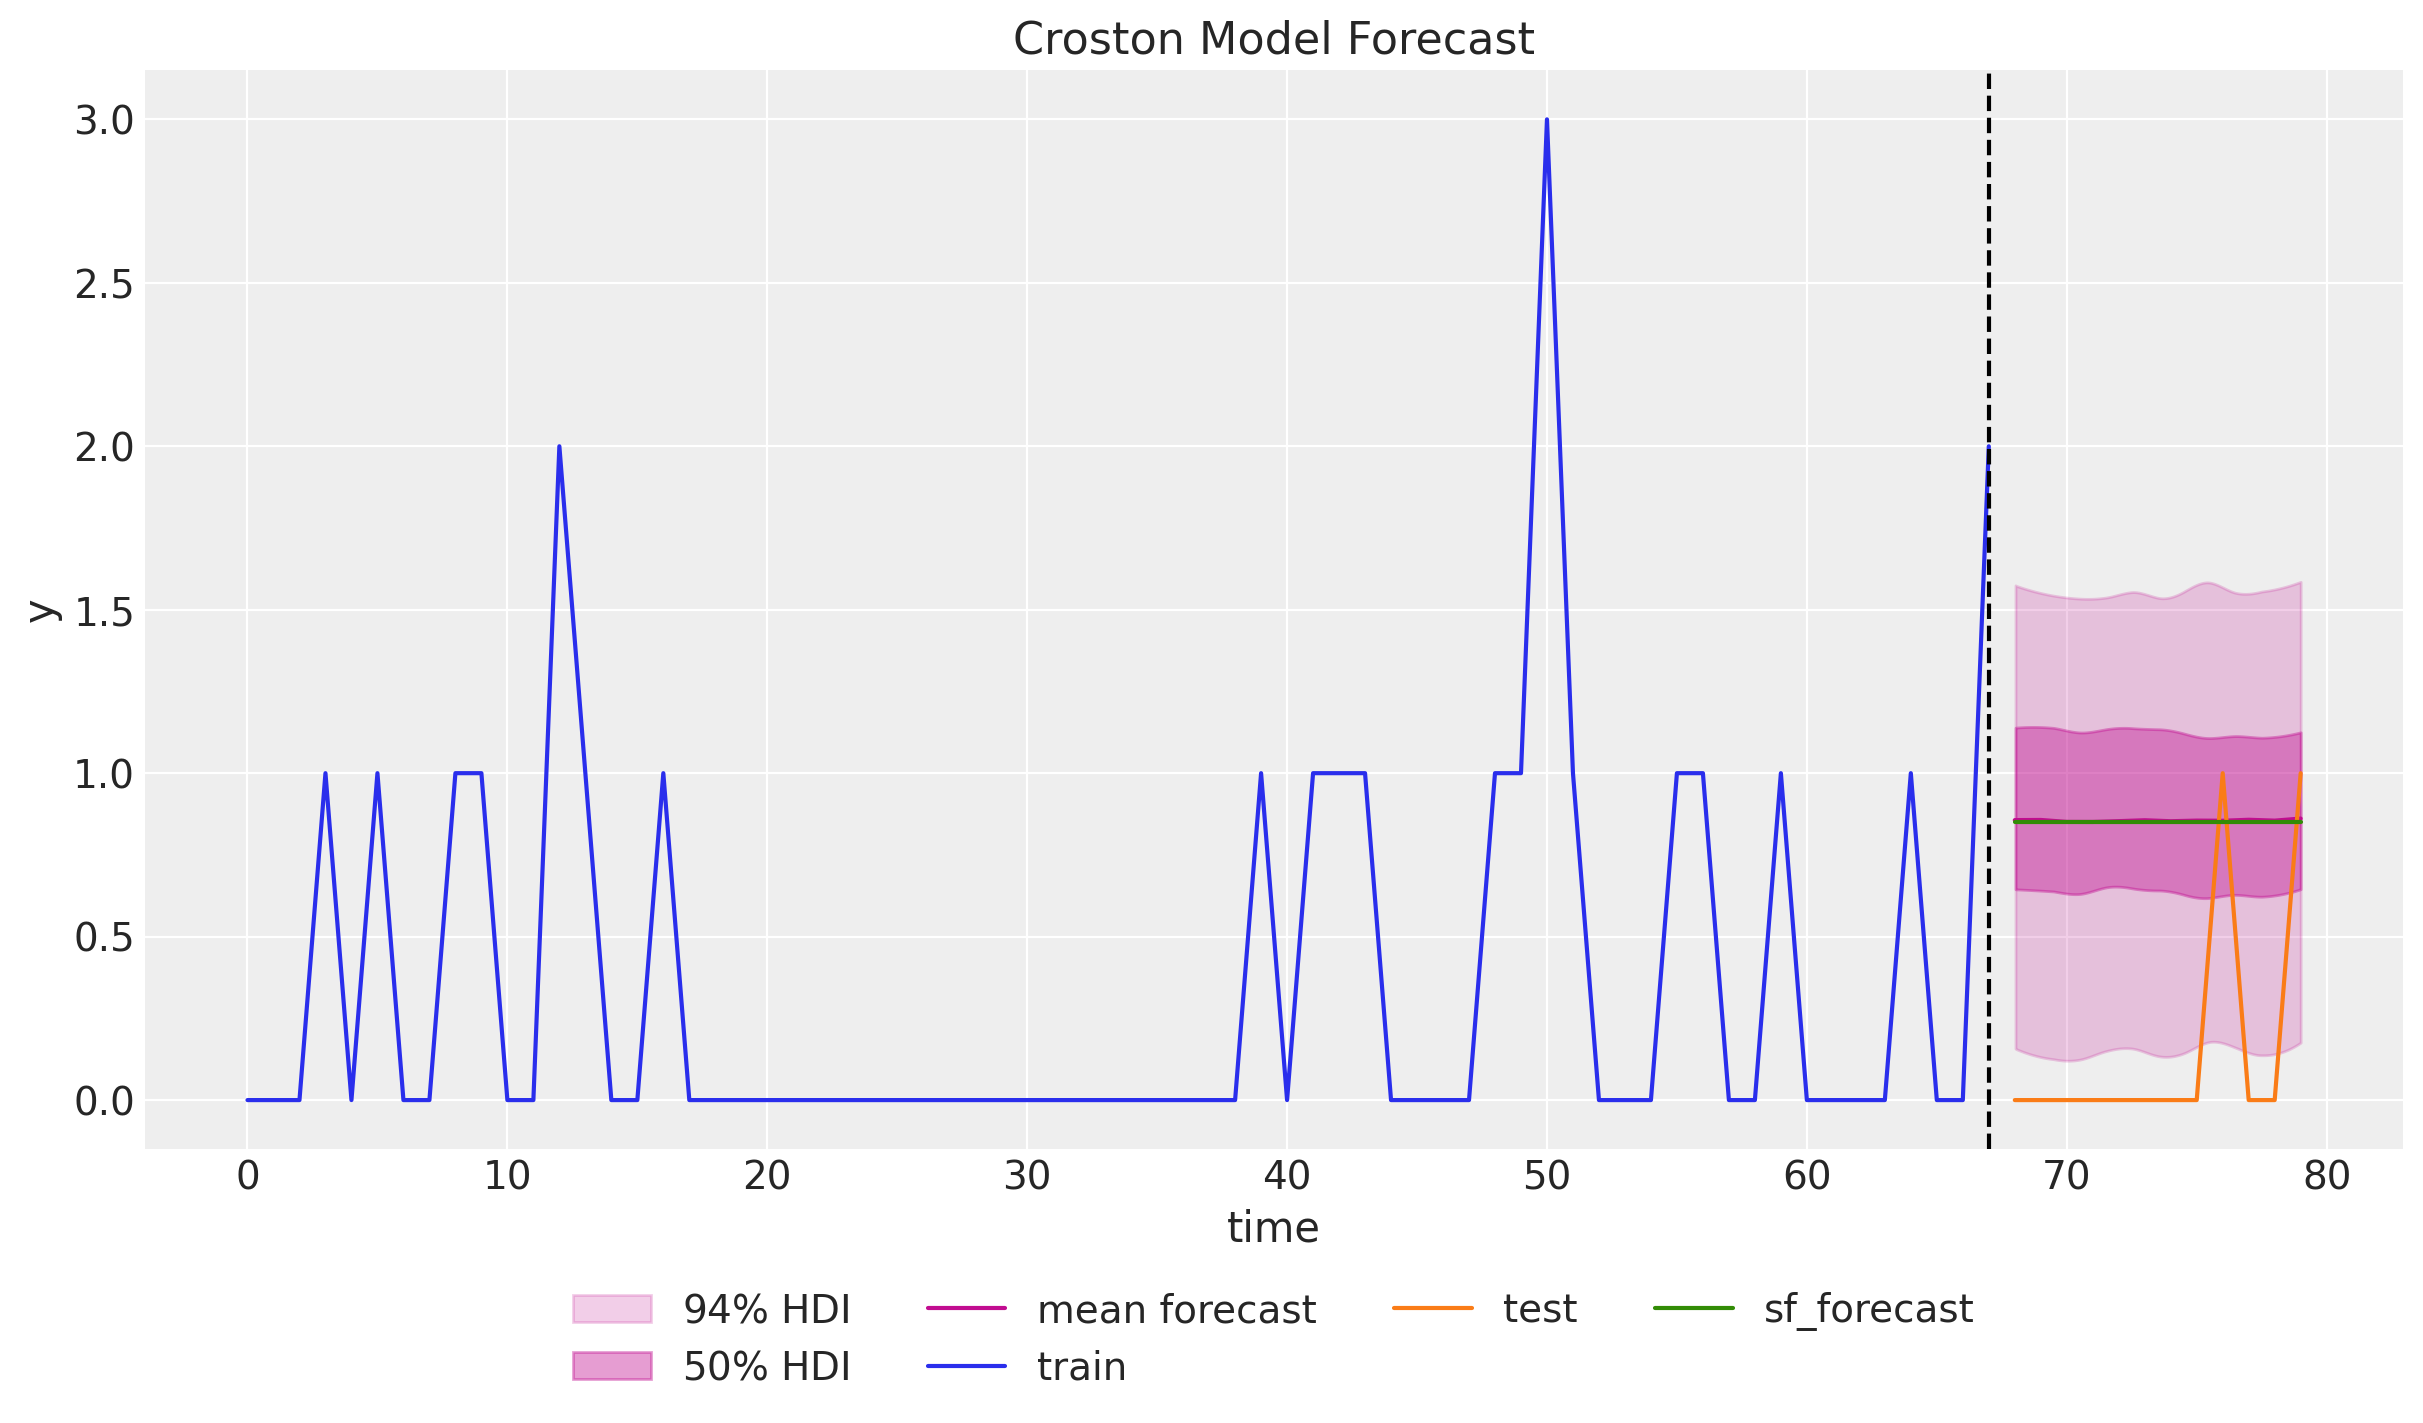

In [16]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["ts_forecast"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["ts_forecast"],
    hdi_prob=0.50,
    color="C3",
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["ts_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.plot(t_test, sf_forecast["TSB"], color="C2", label="sf_forecast")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="time", ylabel="y", title="Croston Model Forecast")

## Time Slice Cross Validation

In [17]:
def tsb_time_slice_cross_validation(
    rng_key: ArrayImpl, y: ArrayImpl, n_splits: int, inference_params: InferenceParams
) -> list[az.InferenceData]:
    forecast_list = []
    for i in tqdm(range(n_splits)):
        # Prepare data
        y_train = y[: -(n_splits - i)]
        y_train_trim, z0, p0 = get_model_args(y_train)
        # Inference
        rng_key, rng_subkey = random.split(key=rng_key)
        mcmc = run_inference(
            rng_subkey, tsb_model, inference_params, y_train_trim, z0, p0
        )
        # Forecast
        rng_key, rng_subkey = random.split(key=rng_key)
        tsb_forecast = forecast(
            rng_subkey, tsb_model, mcmc.get_samples(), y_train_trim, z0, p0, 1
        )
        forecast_list.append(
            az.from_numpyro(
                posterior_predictive=tsb_forecast,
                coords={"t": [y_train_trim.size]},
                dims={"ts_forecast": ["t"]},
            )
        )
    return forecast_list

In [18]:
rng_key, rng_subkey = random.split(key=rng_key)
forecast_list = tsb_time_slice_cross_validation(
    rng_subkey, y, y_test.size, inference_params
)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [19]:
forecast_cv = xr.concat(
    [x["posterior_predictive"] for x in forecast_list],
    dim=("t"),
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Croston Model Forecast - 1 Step Ahead Cross-Validation')]

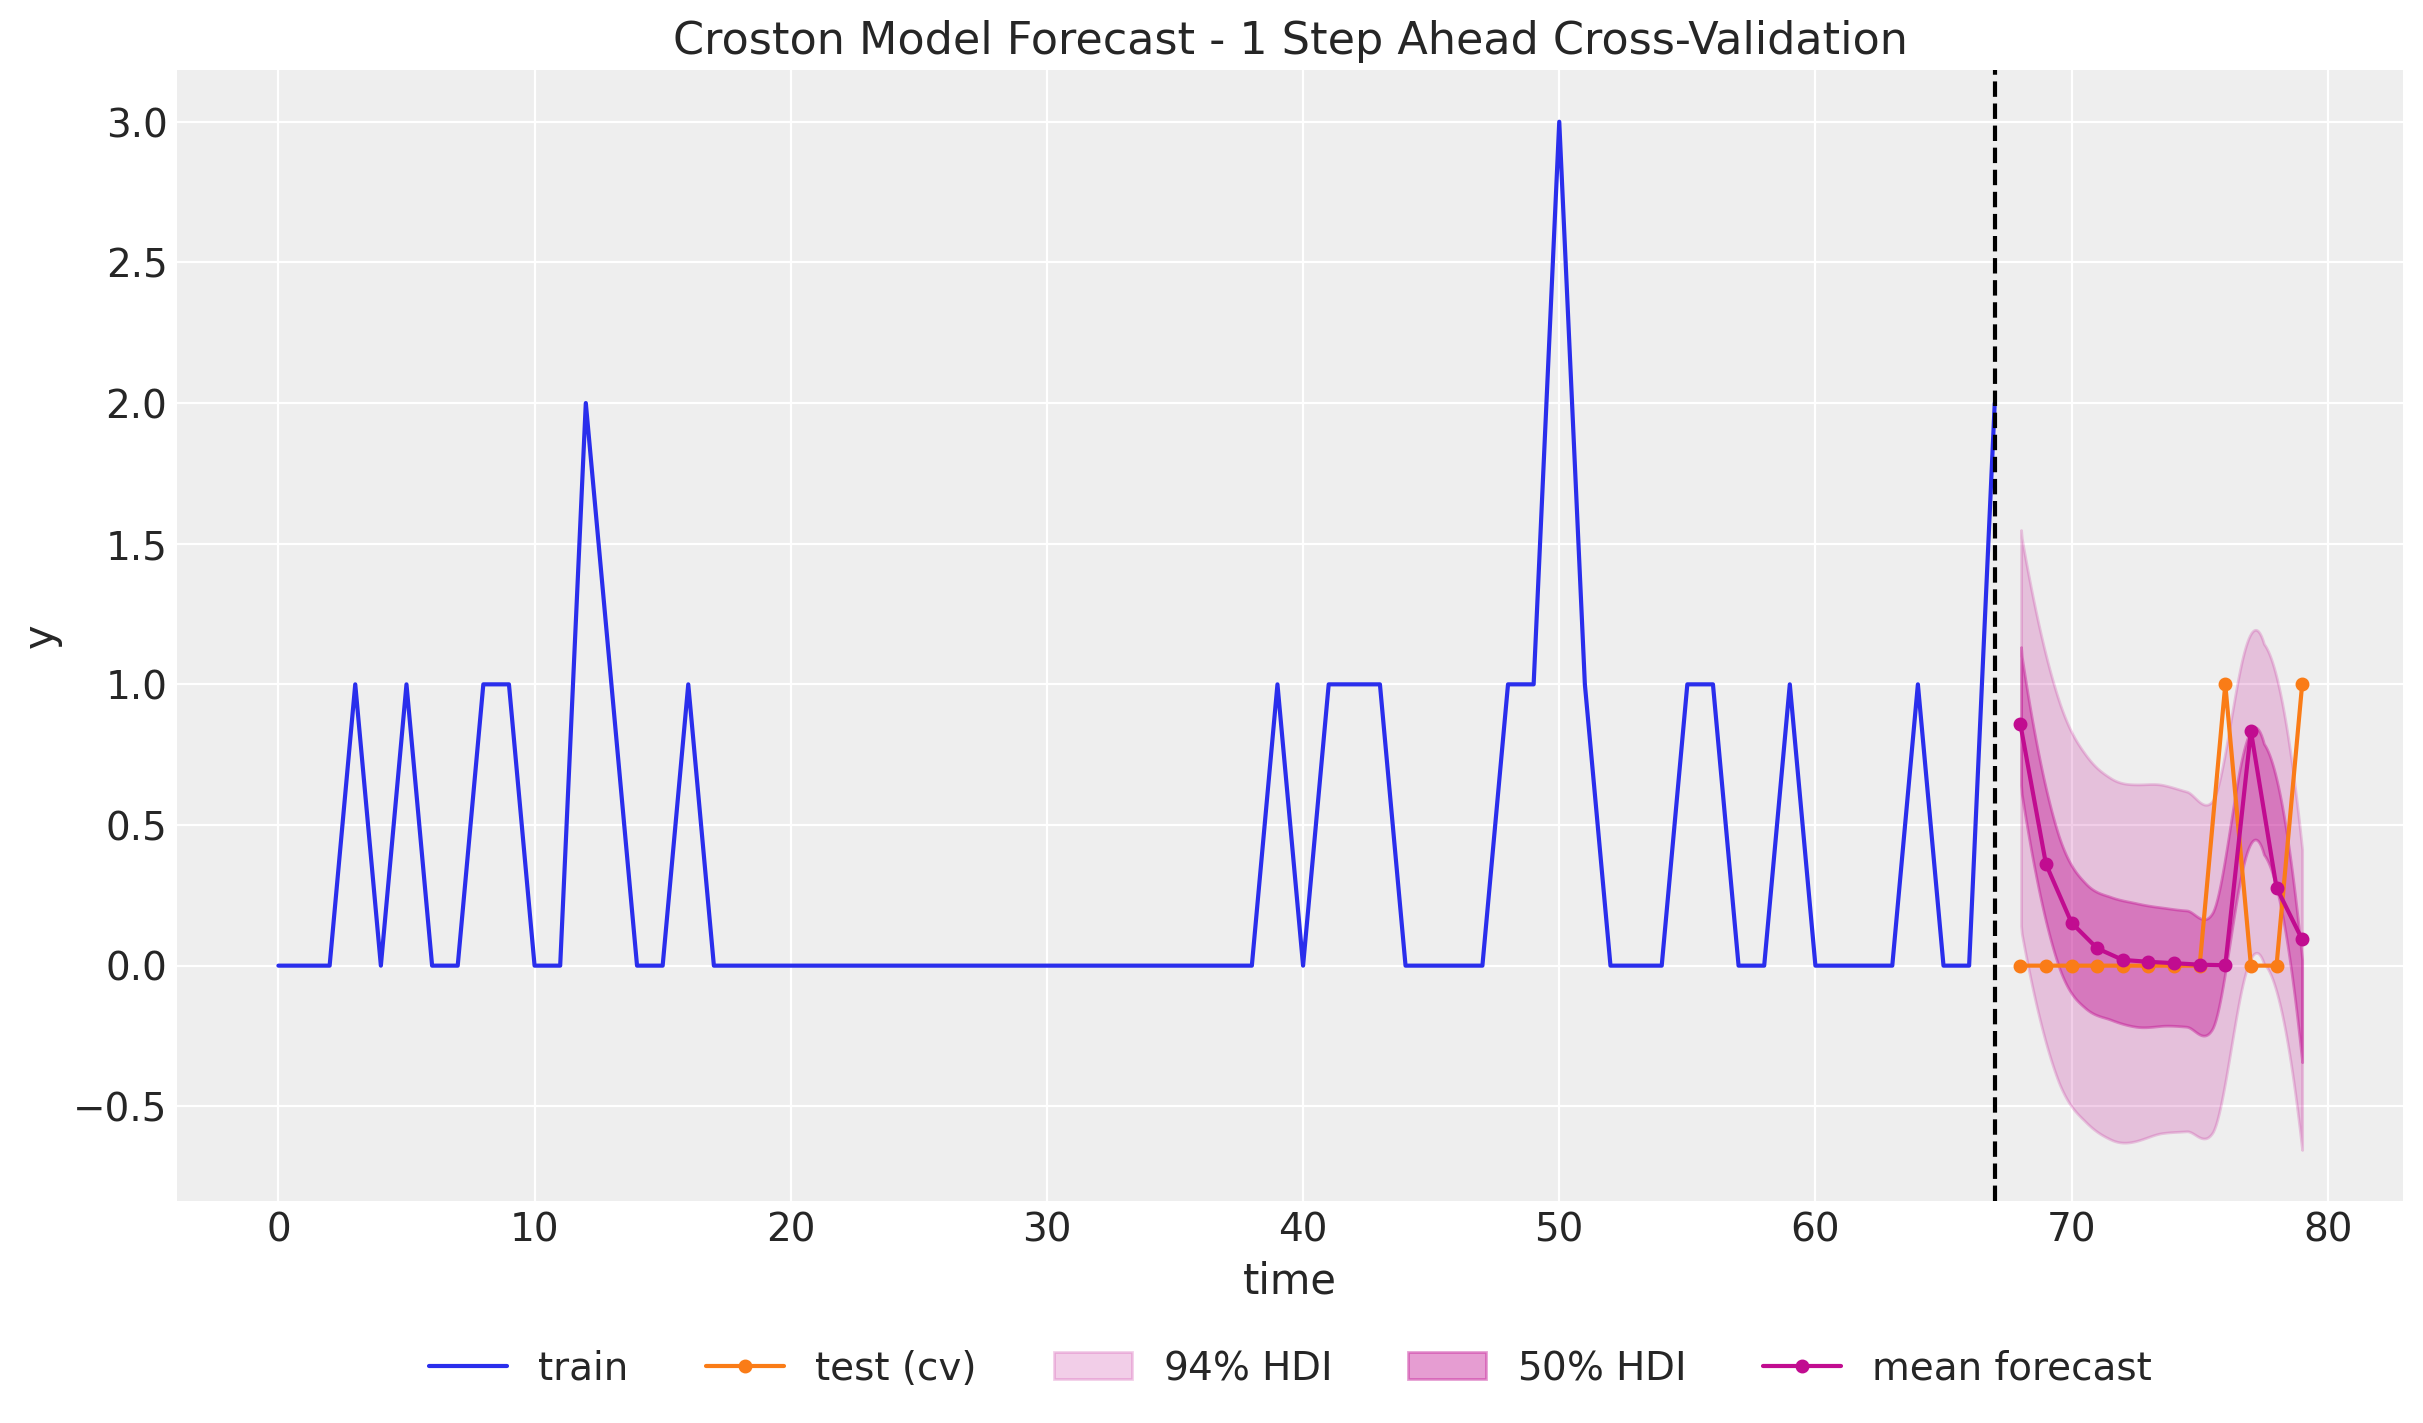

In [25]:
fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, marker="o", markersize=4, color="C1", label="test (cv)")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
az.plot_hdi(
    x=t_test,
    y=forecast_cv["ts_forecast"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=forecast_cv["ts_forecast"],
    hdi_prob=0.50,
    color="C3",
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    forecast_cv["ts_forecast"].mean(dim=("chain", "draw")),
    marker="o",
    markersize=4,
    color="C3",
    label="mean forecast",
)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set(
    xlabel="time",
    ylabel="y",
    title="Croston Model Forecast - 1 Step Ahead Cross-Validation",
)